In [1]:
import os
import logging
import numpy as np
from googleapiclient.errors import HttpError
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google_auth_oauthlib.flow import InstalledAppFlow
from googleapiclient.discovery import build

# Configuração do logging
logging.basicConfig(level=logging.INFO)


## Funções
def autenticar_google_sheets():
    token_path = os.getenv("TOKEN_PATH", "token.json")
    client_secret_path = os.getenv("CLIENT_SECRET_PATH", "client_secret.json")
    SCOPES = ["https://www.googleapis.com/auth/spreadsheets"]
    """Autentica no Google Sheets e retorna o serviço para manipular planilhas."""
    creds = None

    # Verifica se o token de autenticação já existe
    if os.path.exists(token_path):
        creds = Credentials.from_authorized_user_file(token_path, SCOPES)
        logging.info("Token carregado com sucesso.")

    # Se não houver credenciais válidas, faz a autenticação
    if not creds or not creds.valid:
        if creds and creds.expired and creds.refresh_token:
            try:
                creds.refresh(Request())
                logging.info("Token atualizado.")
            except Exception as e:
                logging.error(f"Erro ao atualizar token: {e}")
                return None
        else:
            try:
                flow = InstalledAppFlow.from_client_secrets_file(client_secret_path, SCOPES)
                creds = flow.run_local_server(port=0)
                logging.info("Nova autenticação realizada com sucesso.")
            except FileNotFoundError:
                logging.error("Arquivo 'client_secret.json' não encontrado.")
                return None
            except Exception as e:
                logging.error(f"Erro na autenticação: {e}")
                return None

        # Salva as credenciais para futuras execuções
        with open(token_path, "w") as token:
            token.write(creds.to_json())
            logging.info("Token salvo para futuras execuções.")

    return build("sheets", "v4", credentials=creds)

def obter_dados_planilha(service, spreadsheet_id, range_name):
    """Obtém os dados de uma planilha do Google Sheets."""
    if service is None:
        logging.error("O serviço do Google Sheets não foi autenticado corretamente.")
        return None

    try:
        sheet = service.spreadsheets()
        result = sheet.values().get(spreadsheetId=spreadsheet_id, range=range_name).execute()
        painel_dados = result.get("values", [])

        if not painel_dados:
            logging.warning(f"Nenhum dado encontrado no intervalo '{range_name}'.")
            return []
        
        logging.info(f"Dados obtidos com sucesso do intervalo '{range_name}'.")
        return painel_dados

    except HttpError as http_err:
        logging.error(f"Erro HTTP ao acessar a planilha: {http_err}")
    except Exception as e:
        logging.error(f"Erro inesperado ao obter dados da planilha: {e}")
    
    return None


def remover_ultimo_elemento_numerico(lista):
    idx_ultimo = np.where(~np.isnan(lista))[0]
    if len(idx_ultimo) > 0:
        lista[idx_ultimo[-1]] = np.nan

INFO:root:Token carregado com sucesso.
INFO:root:Token atualizado.
INFO:root:Token salvo para futuras execuções.
INFO:googleapiclient.discovery_cache:file_cache is only supported with oauth2client<4.0.0
INFO:root:Dados obtidos com sucesso do intervalo 'Vendas!A:G'.
INFO:root:Dados obtidos com sucesso do intervalo 'Painel!A:AL'.


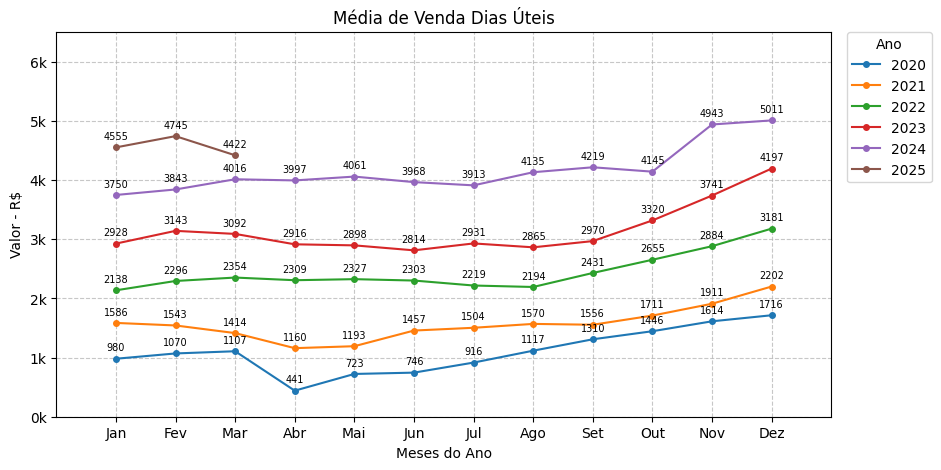

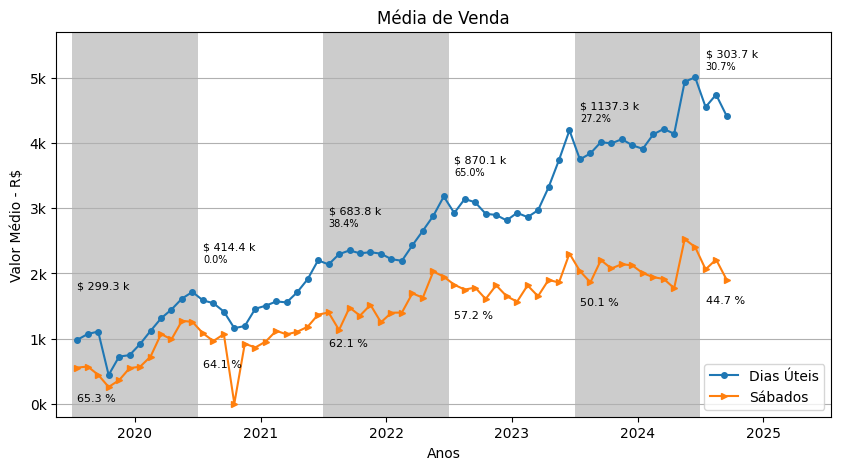

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

# Definição do escopo de acesso ao Google Sheets
service = autenticar_google_sheets()
SPREADSHEET_ID = "1td40BQ7k6heUOjKamm10gbb93hHYpkbIykDPu6IwJHU"

vendas_dados = obter_dados_planilha(service, SPREADSHEET_ID, "Vendas!A:G")
painel_dados = obter_dados_planilha(service, SPREADSHEET_ID, "Painel!A:AL")

data = pd.DataFrame(vendas_dados[2:], columns=vendas_dados[0])
painel = pd.DataFrame(painel_dados[1:], columns=painel_dados[0])


# Tratamento de valores vazios e conversão de tipos
painel.replace('', np.nan, inplace=True)
painel.dropna(subset=['ANO'], inplace=True)

painel['SABADOS'] = pd.to_numeric(painel['SABADOS'].str.replace(',', '.'), errors='coerce')
painel['DIAS SEMANA'] = pd.to_numeric(painel['DIAS SEMANA'].str.replace(',', '.'), errors='coerce')

# Tratamento dos valores vendidos no cartão
data.loc[:, 'VENDA DIÁRIA'] = (data['VENDA DIÁRIA']
                               .str.replace(r'R\$', '', regex=True)
                               .str.replace(r'\.', '', regex=True)
                               .str.replace(',', '.', regex=True)
                               .astype(float))
##############################################
# Criando listas de anos, meses e dias úteis
mes_incompleto = False # Variável para indicar se o mês é incompleto
ano_inicial, ano_corte, ano_final = 2020, 2022, 2026

yearlist = [str(num) for num in range(ano_inicial, ano_final)]
month = [str(num) for num in range(1, 13)]
workday = [str(num) for num in range(2, 7)]
saturday = ['7']

# Criando listas de vendas médias para dias úteis e sábados
wd_array, sat_array = [], []

for ano in yearlist:
    for mes in month:
        # Filtrando vendas para dias úteis
        data_filt_wd = data[(data['DIA DA SEMANA'].isin(workday)) &
                            (data['ANO'] == ano) &
                            (data['MÊS'] == mes) &
                            (data['VENDA DIÁRIA'] > 0)]
        
        # Filtrando vendas para sábados
        data_filt_sat = data[(data['DIA DA SEMANA'].isin(saturday)) &
                             (data['ANO'] == ano) &
                             (data['MÊS'] == mes) &
                             (data['VENDA DIÁRIA'] > 0)]

        wd_array.append(data_filt_wd['VENDA DIÁRIA'].dropna().mean())
        sat_array.append(data_filt_sat['VENDA DIÁRIA'].dropna().mean())

# Removendo último valor caso o mês seja incompleto
if mes_incompleto:
    remover_ultimo_elemento_numerico(wd_array)
    remover_ultimo_elemento_numerico(sat_array)

## Grafico 1 -media de vendas dias uteis 
# Definir número de partes e dividir a lista wd_array
num_partes = 12
wd_array = np.array(wd_array)  # Converte para array NumPy para facilitar manipulação
wd_array = wd_array[~np.isnan(wd_array)]  # Remove valores NaN para evitar problemas
partes = [wd_array[i:i + num_partes] for i in range(0, len(wd_array), num_partes)]
meses_do_ano = ['Jan', 'Fev', 'Mar', 'Abr', 'Mai', 'Jun', 'Jul', 'Ago', 'Set', 'Out', 'Nov', 'Dez']

# Criar o gráfico
plt.figure(figsize=(10, 5))
for idx, lista in enumerate(partes):
    plt.plot(lista, marker='o', markersize=4, label=yearlist[idx])
    # Adicionar valores no gráfico
    for x in range(len(lista)):
        if not np.isnan(lista[x]):  # Verifica se não é NaN
            plt.text(x, lista[x] + 100, round(lista[x]), ha='center', va='bottom', fontsize=7)

# Personalização do gráfico
plt.xlabel('Meses do Ano')
plt.ylabel('Valor - R$')
plt.title('Média de Venda Dias Úteis')
plt.xticks(range(len(meses_do_ano)), meses_do_ano)
plt.ylim(0, wd_array.max() + 1500)
plt.xlim(-1, 12)
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1000:,.0f}k')) # Formatador do eixo Y (milhares com 'k')
plt.legend(title='Ano', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
# Listas de armazenamento
venda_anual = []
venda_anual_wd = []
venda_anual_sat = []
porc_aum_anual = []

for i in yearlist:
    venda_anual.append(int(data.loc[data['ANO'] == i, 'VENDA DIÁRIA'].sum()))

    # Média para dias úteis (excluindo domingo e sábado)
    mean_wd = data.loc[(~data['DIA DA SEMANA'].isin(['7', '1'])) & (data['ANO'] == i) & (data['VENDA DIÁRIA'] > 0),'VENDA DIÁRIA'].mean()
    venda_anual_wd.append(0 if pd.isna(mean_wd) else int(mean_wd))

    # Média para sábados
    mean_sat = data.loc[(data['DIA DA SEMANA'] == '7') & (data['ANO'] == i) & (data['VENDA DIÁRIA'] > 0),'VENDA DIÁRIA'].mean()     
    venda_anual_sat.append(0 if pd.isna(mean_sat) else int(mean_sat))

    # Cálculo da variação percentual anual
    k = yearlist.index(i)
    if k > 0 and venda_anual[k-1] != 0:
        porc_aum_anual.append((venda_anual[k] - venda_anual[k-1]) / venda_anual[k-1])
    else:
        porc_aum_anual.append(0)

porc_sab_wd = np.divide(np.array(venda_anual_sat), np.array(venda_anual_wd), out=np.zeros_like(np.array(venda_anual_sat), dtype=float), where=np.array(venda_anual_wd) != 0)

# Criar a figura
fig1 = plt.figure(figsize=(10, 5))
plt.xlabel('Anos')
plt.ylabel('Valor Médio - R$')
plt.title('Média de Venda')


#rotulos anuais para cada barra
plt.xticks(np.arange(5.5, len(yearlist)*12+1, 12), yearlist)
# rotulo eixo vertical esquerdo abreviado RS X k 
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1000:,.0f}k'))
# altura do gráfico no eixo y, usando maximo valor da série somando com 600
plt.ylim(-200, max(wd_array)+700)
plt.xlim(-2, (len(yearlist)*12))
# linhas de grade horizontal
plt.grid(axis='y')

# definindo e plotando as séries
plt.plot(wd_array,marker='o',markersize=4,label='Dias Úteis') 
plt.plot(sat_array,marker='>',markersize=4,label='Sábados')  

# Desenhar o plano de fundo listrado
for i in range(0, len(yearlist)*12+1, 24):
    if i % 4 == 0:
        if i < (len(yearlist)*12):
            plt.axvspan(i-0.5, i+11.5, facecolor='gray', alpha=0.4)
    else:
        plt.axvspan(i-0.5, i+11.5, facecolor='gray', alpha=0.4)

#Adicionando venda anual e rótulos a cada 12 pontos de wd array
for i in range(0, len(wd_array), 12):
    plt.text(i, wd_array[i]+900, f'$ {venda_anual[i//12]/1000:.1f} k', fontsize=8, verticalalignment='top')
    plt.text(i, sat_array[i] -400, f'{porc_sab_wd[i//12]*100:.1f} %', fontsize=8, verticalalignment='top')
    if i > 0:
        mes_final_prev = int(np.sum(~np.isnan(wd_array))%12)
        mes_final = 12 if mes_final_prev == 0 else mes_final_prev
        #colocar um percentual proporcional nesse if, else com condição anual
        meses_atual = [str(i) for i in range(1, mes_final+1)]
        if (len(porc_aum_anual) == i//12) and (mes_final != 0):
            num = int(data.loc[(data['MÊS'].isin(meses_atual)) & (data['ANO'] == yearlist[-1]), 'VENDA DIÁRIA'].sum())
            den = int(data.loc[(data['MÊS'].isin(meses_atual)) & (data['ANO'] == yearlist[-2]), 'VENDA DIÁRIA'].sum())
            plt.text(i, wd_array[i]+700, f'{(num-den)*100/den:.1f}%', fontsize=7, verticalalignment='top')
        else:
            plt.text(i, wd_array[i]+700, f'{(100*porc_aum_anual[i//12-1]):.1f}%', fontsize=7, verticalalignment='top')
        

plt.legend()
plt.show()

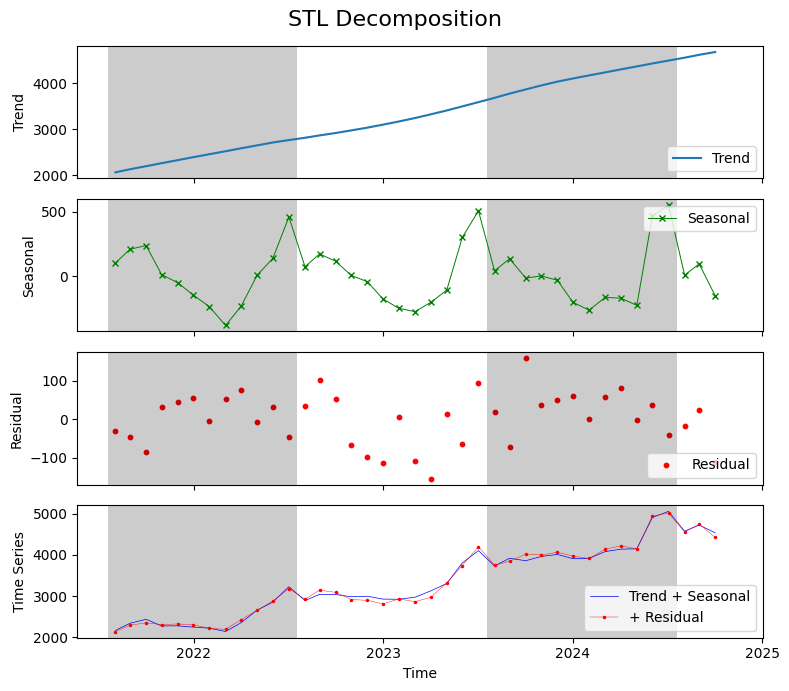

In [38]:
from statsmodels.tsa.seasonal import STL

#converte np.float64 em inteiro e exclui NAN (meses zerados) em lista
wd_int = [int(x) for x in wd_array if not np.isnan(x)]
sat_int = [int(x) for x in sat_array if not np.isnan(x)]
# definir lista apartir de ano de corte
wd_int = wd_int[((ano_corte-ano_inicial)*12):]
sat_int = sat_int[((ano_corte-ano_inicial)*12):]

#converte lista em ts
tsw = pd.Series(wd_int, index=pd.date_range("1-"+str(ano_corte), periods=len(wd_int), freq="ME"), name="month mean")
tss = pd.Series(sat_int, index=pd.date_range("1-"+str(ano_corte), periods=len(wd_int), freq="ME"), name="month mean")

#STL decomposition
stl = STL(tsw, seasonal=13) #specifying a seasonal period of 13 (which corresponds to a seasonal cycle length of 12 months).
STL_decomp = stl.fit()

# Supondo que você já tenha realizado a decomposição STL e tenha o objeto STL_decomp
n_points = len(STL_decomp.seasonal)
dates = pd.date_range(start=str(ano_corte)+"-01-01", periods=n_points, freq="ME")

# Extract components
trend = STL_decomp.trend
seasonal = STL_decomp.seasonal
residual = STL_decomp.resid

# Plotting the components
fig, axs = plt.subplots(4, 1, figsize=(8,7), sharex=True)

# Plot the trend component
axs[0].plot(trend, label='Trend')
axs[0].set_ylabel('Trend')
axs[0].legend(loc='lower right')

# Plot the seasonal component
axs[1].plot(seasonal, label='Seasonal', color='green',marker='x',markersize=4,linewidth=0.7)
axs[1].set_ylabel('Seasonal')
axs[1].legend(loc='upper right')

# Plot the residual component
axs[2].scatter(dates,residual, label='Residual', color='red',s=10)
axs[2].set_ylabel('Residual')
axs[2].legend(loc='lower right')

# Plot the residual component
axs[3].plot(seasonal+trend, label='Trend + Seasonal', color='blue',linewidth=0.5)
            #,marker='x',markersize=5, markeredgewidth=1, markeredgecolor='green')
axs[3].plot(seasonal+trend+residual, label='+ Residual', color='red',marker='o',markersize=1.5,linewidth=0.3)
#axs[3].scatter(dates,seasonal+trend+(residual*5), label='Residual 5X', color='red',s=3)
axs[3].set_ylabel('Time Series')
axs[3].legend(loc='lower right')

# Common x-axis label
axs[3].set_xlabel('Time')

#print(np.arange(ano_corte,ano_final))
for j in range(4):
    for i in np.arange(ano_corte,ano_final):
        if i % 2 == 0:
            date_ini = len(pd.date_range(start='1970-01-01', end=str(i)+'-1-15', freq='D'))
            date_fin = len(pd.date_range(start='1970-01-01', end=str(i+1)+'-1-15', freq='D'))
            axs[j].axvspan(date_ini,date_fin, facecolor='black', alpha=0.2)

#define dia interio domeio do ano do ano corte
date_rng = len(pd.date_range(start='1970-01-01', end=str(ano_corte)+'-6-30', freq='D'))
#definindo legenda anual eixo X
plt.xticks(np.arange(date_rng, date_rng+(ano_final-ano_corte)*365, 365), yearlist[(ano_corte-ano_inicial):])

# Title
fig.suptitle('STL Decomposition', fontsize=16)

plt.tight_layout()
plt.show()

In [39]:
from statsmodels.tsa.ar_model import AutoReg

#STL decomposition
stl = STL(tsw, seasonal=13) #period=12
STL_decomp = stl.fit()
#fig2 = STL_decomp.plot()

A = STL_decomp.trend + STL_decomp.resid

# fig3 = plt.figure("Figure 3")
# plt.plot(A, c="red", lw=2)
# plt.plot(STL_decomp.trend, c="blue", lw=1)
# plt.legend(['Trend + Resid', 'Trend'])


model = AutoReg(A,lags=12)
model_fit = model.fit()
pdt = model_fit.predict(start=tsw.index[-1] + pd.DateOffset(months=1),
                        end=tsw.index[-1] + pd.DateOffset(months=12))

B = STL_decomp.seasonal
B12 = np.zeros(12)
#replicando sazonalidade dos ultimos 12 meses
B12 = B[-12:]
B12.index = B12.index + pd.DateOffset(years=1)

#print((pdt+B12).astype(int))
#print(ts[-12:])

tsw_pdt = pd.concat([tsw,(pdt+B12).astype(int)])


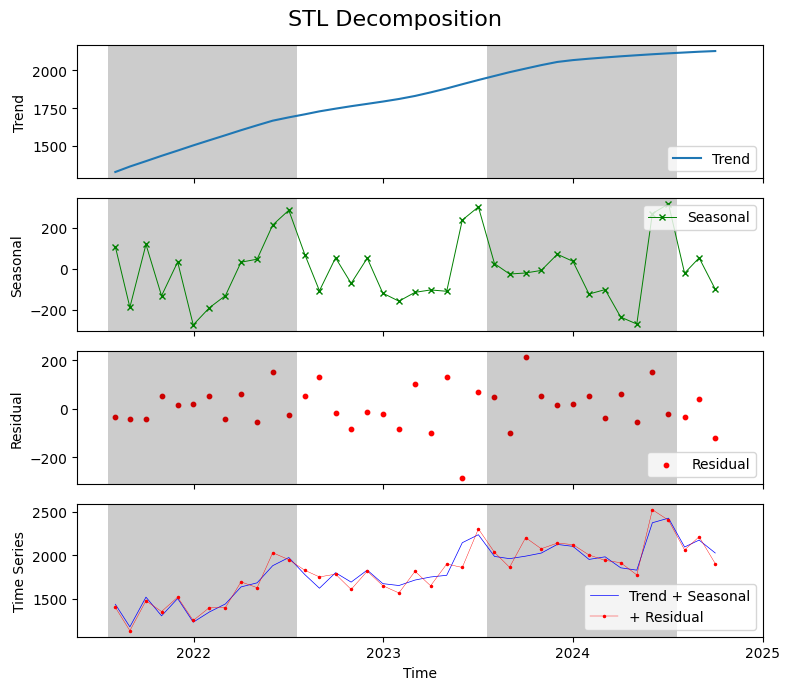

In [40]:
#STL decomposition
stl = STL(tss, seasonal=13) #specifying a seasonal period of 13 (which corresponds to a seasonal cycle length of 12 months).
STL_decomp = stl.fit()

# Supondo que você já tenha realizado a decomposição STL e tenha o objeto STL_decomp
n_points = len(STL_decomp.seasonal)
dates = pd.date_range(start=str(ano_corte)+"-01-01", periods=n_points, freq="ME")

# Extract components
trend = STL_decomp.trend
seasonal = STL_decomp.seasonal
residual = STL_decomp.resid

# Plotting the components
fig, axs = plt.subplots(4, 1, figsize=(8,7), sharex=True)

# Plot the trend component
axs[0].plot(trend, label='Trend')
axs[0].set_ylabel('Trend')
axs[0].legend(loc='lower right')


# Plot the seasonal component
axs[1].plot(seasonal, label='Seasonal', color='green',marker='x',markersize=4,linewidth=0.7)
axs[1].set_ylabel('Seasonal')
axs[1].legend(loc='upper right')

# Plot the residual component
axs[2].scatter(dates,residual, label='Residual', color='red',s=10)
axs[2].set_ylabel('Residual')
axs[2].legend(loc='lower right')

# Plot the residual component
axs[3].plot(seasonal+trend, label='Trend + Seasonal', color='blue',linewidth=0.5)
            #,marker='x',markersize=5, markeredgewidth=1, markeredgecolor='green')
axs[3].plot(seasonal+trend+residual, label='+ Residual', color='red',marker='o',markersize=1.5,linewidth=0.3)
#axs[3].scatter(dates,seasonal+trend+(residual*5), label='Residual 5X', color='red',s=3)
axs[3].set_ylabel('Time Series')
axs[3].legend(loc='lower right')

# Common x-axis label
axs[3].set_xlabel('Time')

#print(np.arange(ano_corte,ano_final))
for j in range(4):
    for i in np.arange(ano_corte,ano_final):
        if i % 2 == 0:
            date_ini = len(pd.date_range(start='1970-01-01', end=str(i)+'-1-15', freq='D'))
            date_fin = len(pd.date_range(start='1970-01-01', end=str(i+1)+'-1-15', freq='D'))
            axs[j].axvspan(date_ini,date_fin, facecolor='black', alpha=0.2)

#define dia interio domeio do ano do ano corte
date_rng = len(pd.date_range(start='1970-01-01', end=str(ano_corte)+'-6-30', freq='D'))
#definindo legenda anual eixo X
plt.xticks(np.arange(date_rng, date_rng+(ano_final-ano_corte)*365, 365), yearlist[(ano_corte-ano_inicial):])

# Title
fig.suptitle('STL Decomposition', fontsize=16)

plt.tight_layout()
plt.show()

In [41]:
#STL decomposition
stl = STL(tss, seasonal=13) #period=12
STL_decomp = stl.fit()
#fig2 = STL_decomp.plot()

A = STL_decomp.trend + STL_decomp.resid

# fig3 = plt.figure("Figure 3")
# plt.plot(A, c="red", lw=2)
# plt.plot(STL_decomp.trend, c="blue", lw=1)
# plt.legend(['Trend + Resid', 'Trend'])


model = AutoReg(A,lags=12)
model_fit = model.fit()
pdt = model_fit.predict(start=tss.index[-1] + pd.DateOffset(months=1),
                        end=tss.index[-1] + pd.DateOffset(months=12))

B = STL_decomp.seasonal
B12 = np.zeros(12)
#replicando sazonalidade dos ultimos 12 meses
B12 = B[-12:]
B12.index = B12.index + pd.DateOffset(years=1)

#print((pdt+B12).astype(int))
#print(ts[-12:])

tss_pdt = pd.concat([tss,(pdt+B12).astype(int)])
#print(tss_pdt[-12:])
#print(tsw_pdt[-12:])

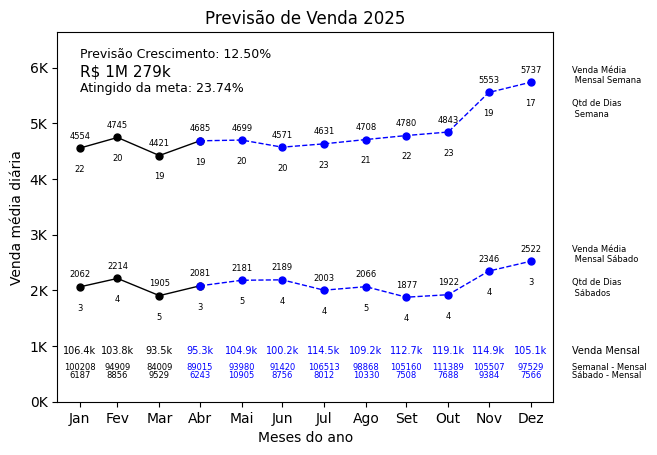

In [43]:
num_mes = len(tsw_pdt)%12
num_mes = 12 if num_mes == 0 else num_mes
mksz = 5
lnsz = 1

# serie semana
plt.plot(tsw_pdt[-12-num_mes:-11],marker='o',c='black',markersize=mksz,linewidth=lnsz)
plt.plot(tsw_pdt[-12:-num_mes],marker='o',c='blue',linestyle='--',markersize=mksz,linewidth=lnsz)
# serie sabado
plt.plot(tss_pdt[-12-num_mes:-11],marker='o',c='black',markersize=mksz,linewidth=lnsz)
plt.plot(tss_pdt[-12:-num_mes],marker='o',c='blue',linestyle='--', markersize=mksz,linewidth=lnsz)

venda_do_ano = 0
for i in range(12):
    plt.text(tsw_pdt.index[-12-num_mes+i], tsw_pdt.iloc[-12-num_mes+i]+300, f'{tsw_pdt.iloc[-12-num_mes+i]}', fontsize=6, va='top',ha='center')
    plt.text(tss_pdt.index[-12-num_mes+i], tss_pdt.iloc[-12-num_mes+i]+300, f'{tss_pdt.iloc[-12-num_mes+i]}', fontsize=6, va='top',ha='center')
    #calcula venda para sábados e dias uteis em cada mes do ano vigente
    mes_aux = str(i+1)
    wd_sum = int(data.loc[(data['DIA DA SEMANA'].isin(['2','3','4','5','6']))
                    & (data['ANO'] == yearlist[-1])
                    & (data['MÊS'] == mes_aux), 'VENDA DIÁRIA'].sum())
    sat_sum = int(data.loc[(data['DIA DA SEMANA'] == '7')
                    & (data['ANO'] == yearlist[-1])
                    & (data['MÊS'] == mes_aux) , 'VENDA DIÁRIA'].sum())
    #calcula dias uteis e sabados trabalhados
    days_wd = painel.loc[(painel['ANO'] == yearlist[-1]) & (painel['MÊS NUM'] == mes_aux),'DIAS SEMANA'].sum()
    days_sat = painel.loc[(painel['ANO'] == yearlist[-1]) & (painel['MÊS NUM'] == mes_aux),'SABADOS'].sum()
    plt.text(tsw_pdt.index[-12-num_mes+i], tsw_pdt.iloc[-12-num_mes+i]-300, f'{days_wd:.0f}', fontsize=6, va='top',ha='center')
    plt.text(tss_pdt.index[-12-num_mes+i], tss_pdt.iloc[-12-num_mes+i]-300, f'{days_sat:.0f}', fontsize=6, va='top',ha='center')

    # Venda ou Previsão Fundo do gráfico - se houver venda no mes printa, se nao estima 
    if wd_sum > 0:
        plt.text(tss_pdt.index[-12-num_mes+i], 1000, f'{(wd_sum+sat_sum)/1000:.1f}k', fontsize=7, va='top',ha='center')
        plt.text(tss_pdt.index[-12-num_mes+i], 700, f'{wd_sum:.0f}', fontsize=6, va='top',ha='center')
        plt.text(tss_pdt.index[-12-num_mes+i], 550, f'{sat_sum:.0f}', fontsize=6, va='top',ha='center')
    else:
        plt.text(tss_pdt.index[-12-num_mes+i], 1000, f'{((tsw_pdt.iloc[-12-num_mes+i]*days_wd)+(tss_pdt.iloc[-12-num_mes+i]*days_sat))/1000:.1f}k', fontsize=7, va='top',ha='center',c='blue')
        plt.text(tss_pdt.index[-12-num_mes+i], 700, f'{tsw_pdt.iloc[-12-num_mes+i]*days_wd:.0f}', fontsize=6, va='top',ha='center',c='blue')
        plt.text(tss_pdt.index[-12-num_mes+i], 550, f'{tss_pdt.iloc[-12-num_mes+i]*days_sat:.0f}', fontsize=6, va='top',ha='center',c='blue')

    venda_do_ano += (tsw_pdt.iloc[-12-num_mes+i]*days_wd)+(tss_pdt.iloc[-12-num_mes+i]*days_sat)

#legenda geral topo esquerdo 
shift = 1200 #altura minima da estrutura de legenda
plt.text(tsw_pdt.index[-12-num_mes], tsw_pdt.iloc[-12-num_mes]+shift+300, f'R$ {venda_do_ano/1000000:.0f}M {(venda_do_ano%1000000)/1000:.0f}k', fontsize=11, va='top',ha='left')
venda_atual = int(data.loc[(data['MÊS'].isin(meses_atual)) & (data['ANO'] == yearlist[-1]), 'VENDA DIÁRIA'].sum())
plt.text(tsw_pdt.index[-12-num_mes], tsw_pdt.iloc[-12-num_mes]+shift, f'Atingido da meta: {(venda_atual/venda_do_ano)*100:.2f}%', fontsize=9, va='top',ha='left')
venda_ano_anterior = int(data.loc[(data['ANO'] == yearlist[-2]), 'VENDA DIÁRIA'].sum())
plt.text(tsw_pdt.index[-12-num_mes], tsw_pdt.iloc[-12-num_mes]+shift+600, f'Previsão Crescimento: {((venda_do_ano/venda_ano_anterior)-1)*100:.2f}%', fontsize=9, va='top',ha='left')

plt.xticks(tsw_pdt.index[-12-num_mes:-num_mes], meses_do_ano)  # Definindo os rótulos do eixo x como meses do ano
plt.ylim(0, max(tsw_pdt.iloc[-12-num_mes:-num_mes])+900)

#titulos e eixos
plt.title('Previsão de Venda '+yearlist[-1])
plt.xlabel('Meses do ano')
plt.ylabel('Venda média diária')
#plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter("R$ {x:,.0f}"))
plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f'{x/1000:,.0f}K'))

#legenda vertical direita
plt.text(tss_pdt.index[-num_mes], 1000, "Venda Mensal", fontsize=7, va='top',ha='left')
plt.text(tss_pdt.index[-num_mes], 700, "Semanal - Mensal", fontsize=6, va='top',ha='left')
plt.text(tss_pdt.index[-num_mes], 550, "Sábado - Mensal", fontsize=6, va='top',ha='left')
plt.text(tsw_pdt.index[-num_mes], tsw_pdt.iloc[-num_mes-1]-300, 'Qtd de Dias\n Semana', fontsize=6, va='top',ha='left')
plt.text(tss_pdt.index[-num_mes], tss_pdt.iloc[-num_mes-1]-300, 'Qtd de Dias\n Sábados', fontsize=6, va='top',ha='left')
plt.text(tsw_pdt.index[-num_mes], tsw_pdt.iloc[-num_mes-1]+300, 'Venda Média\n Mensal Semana', fontsize=6, va='top',ha='left')
plt.text(tss_pdt.index[-num_mes], tss_pdt.iloc[-num_mes-1]+300, 'Venda Média\n Mensal Sábado', fontsize=6, va='top',ha='left')
plt.show()